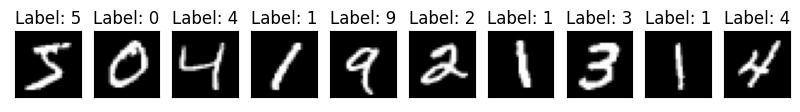

In [8]:
%run -i 'Main.ipynb'

In [1]:
import tensorflow as tf
class VAE(tf.keras.Model):
    def __init__(self, num_hidden):
        super(VAE, self).__init__()

        # Set the number of hidden units
        self.num_hidden = num_hidden

        # Define the encoder part of the VAE
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(784,)),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(self.num_hidden),
        ])

        # Define the decoder part of the VAE
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.num_hidden,)),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(784, activation='sigmoid'),
        ])

        # Add mu and log_var layers for reparameterization
        self.mu = tf.keras.layers.Dense(self.num_hidden)
        self.log_var = tf.keras.layers.Dense(self.num_hidden)

    def reparameterize(self, mu, log_var):
        # Compute the standard deviation from the log variance
        std = tf.math.exp(0.5 * log_var)
        # Generate random noise using the same shape as std
        eps = tf.random.normal(shape=tf.shape(std))
        # Return the reparameterized sample
        return mu + eps * std

    def call(self, x):
        # Pass the input through the encoder
        encoded = self.encoder(x)
        # Compute the mean and log variance vectors
        mu = self.mu(encoded)
        log_var = self.log_var(encoded)
        # Reparameterize the latent variable
        z = self.reparameterize(mu, log_var)
        # Pass the latent variable through the decoder
        decoded = self.decoder(z)
        # Return the encoded output, decoded output, mean, and log variance
        return encoded, decoded, mu, log_var

    def sample(self, num_samples):
        # Generate random noise
        z = tf.random.normal(shape=(num_samples, self.num_hidden))
        # Pass the noise through the decoder to generate samples
        samples = self.decoder(z)
        # Return the generated samples
        return samples
    
    def loss_function(self, recon_x, x, mu, logvar):
        # Compute the binary cross-entropy loss between the reconstructed output and the input data
        BCE = tf.keras.losses.BinaryCrossentropy(from_logits=False)(x, recon_x)
        BCE = tf.reduce_sum(BCE)

        # Compute the Kullback-Leibler divergence between the learned latent variable distribution and a standard Gaussian distribution
        KLD = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar))

        # Combine the two losses by adding them together and return the result
        return BCE + KLD

In [2]:
losses = []
def train_vae(X_train, learning_rate=1e-3, num_epochs=10, batch_size=32):
    # Convert the training data to TensorFlow tensors
    X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
    X_train = tf.reshape(X_train, (X_train.shape[0], 784))

    # Create the VAE model and optimizer
    model = VAE(num_hidden=10)  # Assuming you've defined the VAE class
    optimizer = tf.keras.optimizers.Adam(learning_rate)

    # Create a dataset to handle batching of the training data
    train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
    train_dataset = train_dataset.batch(batch_size).shuffle(buffer_size=len(X_train))

    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch in train_dataset:
            with tf.GradientTape() as tape:
                encoded, decoded, mu, log_var = model(batch)

                # Compute the loss and perform backpropagation
                loss = model.loss_function(decoded, batch, mu, log_var)

            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # Update the running loss
            total_loss += loss.numpy()

        # Print the epoch loss
        epoch_loss = total_loss / len(X_train)
        losses.append(epoch_loss)
        print("Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss))

    # Return the trained model
    return model

In [3]:
learning_rate = 1e-3  # Learning rate
num_epochs = 10  # Number of training epochs
batch_size = 32  # Batch size

# Call the train_vae function to train your VAE
trained_vae = train_vae(X_train, learning_rate, num_epochs, batch_size)

NameError: name 'X_train' is not defined

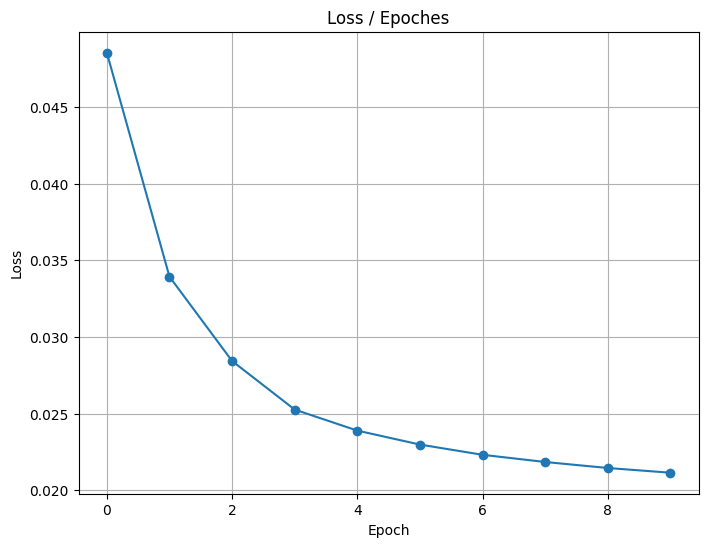

In [22]:
losses

In [ ]:
plot_loss_curve(losses)